In [6]:
 pip install -Uq langgraph langsmith langchain_groq langchain_openai langchain_tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.6 MB/s eta 0:00:00


In [3]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["OPENROUTER_API_KEY"] = userdata.get('OPENROUTER_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "15-LangGraph-Streaming-Steps"

In [7]:
from os import getenv
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
  api_key=getenv("OPENROUTER_API_KEY"),
  base_url="https://openrouter.ai/api/v1",
  model="x-ai/grok-4-fast:free",
  temperature=0
)

In [11]:
llm.invoke("안녕하세요.")

AIMessage(content='안녕하세요! xAI에서 만든 Grok입니다. 무슨 일로 도와드릴까요? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 168, 'prompt_tokens': 122, 'total_tokens': 290, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 143, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 121}}, 'model_name': 'x-ai/grok-4-fast:free', 'system_fingerprint': 'fp_9362061f30', 'id': 'gen-1758872917-cHfTgkZ4Ljbt92HumVgZ', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--437eacd4-07c5-4697-802d-705245178c7c-0', usage_metadata={'input_tokens': 122, 'output_tokens': 168, 'total_tokens': 290, 'input_token_details': {'audio': 0, 'cache_read': 121}, 'output_token_details': {'reasoning': 143}})

In [13]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

In [14]:
def chatbot(state: State) -> State:
  response = llm.invoke(state.get("messages"))
  return State(messages=[response])

In [16]:
from langchain_core.messages import HumanMessage

chatbot(State(messages=[HumanMessage(content="안녕하세요.")]))

{'messages': [AIMessage(content='안녕하세요! 😊 xAI에서 만든 Grok입니다. 무슨 일로 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 203, 'prompt_tokens': 122, 'total_tokens': 325, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 178, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 121}}, 'model_name': 'x-ai/grok-4-fast:free', 'system_fingerprint': 'fp_9362061f30', 'id': 'gen-1758873121-n2eyJpPaBj2NVDOIizjP', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--643be2d9-b8c0-48b6-bf65-6074467a60b5-0', usage_metadata={'input_tokens': 122, 'output_tokens': 203, 'total_tokens': 325, 'input_token_details': {'audio': 0, 'cache_read': 121}, 'output_token_details': {'reasoning': 178}})]}

In [17]:
from langchain_tavily import TavilySearch

search = TavilySearch(max_results=3)
tools = [search]

llm_with_tools = llm.bind_tools(tools)

In [18]:
def chatbot_with_tools(state: State) -> State:
  response = llm_with_tools.invoke(state.get("messages"))
  return State(messages=[response])

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)

In [33]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

builder = StateGraph(State)
builder.add_node("chatbot", chatbot_with_tools)
builder.add_node("tools", tool_node)
builder.add_edge("tools", "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.set_entry_point("chatbot")
graph = builder.compile(checkpointer=memory)

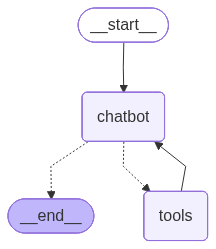

In [34]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for event in graph.stream(input, config, stream_mode="updates"):
  print(event)

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_01815526', 'function': {'arguments': '{"query":"latest AI news","topic":"news","include_favicon":false,"start_date":"2024-10-01","end_date":"2024-10-08"}', 'name': 'tavily_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 606, 'prompt_tokens': 1803, 'total_tokens': 2409, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 522, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1802}}, 'model_name': 'x-ai/grok-4-fast:free', 'system_fingerprint': 'fp_9362061f30', 'id': 'gen-1758874499-kTRHe8ifjCH20z1nDOBP', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e2abc6d2-2eb9-4c0a-9454-4e1d41c8616f-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'latest AI news', 'topic': 'news', 'include_

In [39]:
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for event in graph.stream(input, config, stream_mode="messages"):
  print(event)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--59877a6f-c254-4275-a4d1-f19489817ca0'), {'thread_id': '0.3348238247809542', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:a91c9579-49dc-ac92-c0b7-ac69018d71a8', 'checkpoint_ns': 'chatbot:a91c9579-49dc-ac92-c0b7-ac69018d71a8', 'ls_provider': 'openai', 'ls_model_name': 'x-ai/grok-4-fast:free', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--59877a6f-c254-4275-a4d1-f19489817ca0'), {'thread_id': '0.3348238247809542', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:a91c9579-49dc-ac92-c0b7-ac69018d71a8', 'checkpoint_ns': 'chatbot:a91c9579-49dc-ac92-c0b7-ac69018d71a8', 'l

In [26]:
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for chunk, metadata in graph.stream(input, config, stream_mode="messages"):
  print(metadata)

{'thread_id': '0.8734900516446448', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c', 'checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c', 'ls_provider': 'openai', 'ls_model_name': 'x-ai/grok-4-fast:free', 'ls_model_type': 'chat', 'ls_temperature': 0.0}
{'thread_id': '0.8734900516446448', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c', 'checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c', 'ls_provider': 'openai', 'ls_model_name': 'x-ai/grok-4-fast:free', 'ls_model_type': 'chat', 'ls_temperature': 0.0}
{'thread_id': '0.8734900516446448', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',)

```json
{
  'thread_id': '0.8734900516446448',
  'langgraph_step': 1,
  'langgraph_node': 'chatbot',
  'langgraph_triggers': ('branch:to:chatbot',),
  'langgraph_path': ('__pregel_pull', 'chatbot'),
  'langgraph_checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c',
  'checkpoint_ns': 'chatbot:2e9da640-af3d-0325-d6fa-94578d74691c',
  'ls_provider': 'openai',
  'ls_model_name': 'x-ai/grok-4-fast:free',
  'ls_model_type': 'chat',
  'ls_temperature': 0.0
}
```

In [ ]:
from random import random
from langchain_core.messages import AIMessageChunk
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for chunk, metadata in graph.stream(input, config, stream_mode="messages"):
  if metadata["langgraph_node"] == "chatbot":
    if chunk.content:
      print(chunk.content, end="", flush=True)

In [38]:
from random import random
from langchain_core.messages import AIMessageChunk
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for chunk, metadata in graph.stream(input, config, stream_mode="messages"):
  if isinstance(chunk, AIMessageChunk):
    print(chunk.content, end="", flush=True)
  else:
    print(metadata["langgraph_node"])

tools
### AI 관련 최신 뉴스 (2024년 10월 초 기준)

안녕하세요! AI 관련 최신 뉴스를 검색해 보았습니다. 최근 1주일 내 주요 뉴스를 중심으로 요약해 드리겠습니다. (검색 기준: 2024-10-01 ~ 2024-10-08) 아래는 주요 기사들입니다. 더 자세한 내용은 링크를 클릭해 확인하세요.

1. **Cancer AI Alliance (CAIA) 출범: $40M 투자로 암 치료 AI 협력 강화**  
   - **요약**: 메타(Meta) 등 빅테크 기업들의 지원으로 4천만 달러 규모의 Cancer AI Alliance가 설립되었습니다. 의료 및 기술 전문가들이 연합해 연합 학습(federated learning)을 통해 프라이버시를 보호하면서 AI를 활용한 정밀 의료를 개발합니다. 이는 암 치료의 다음 세대를 위한 중요한 발걸음으로 평가됩니다.  
   - **출처**: TechCrunch  
   - **날짜**: 2024년 10월 2일  
   - **링크**: [TechCrunch 기사](https://techcrunch.com/2024/10/02/cancer-ai-alliance-joins-medical-and-tech-expertise-together-with-40m-to-collaborate-on-next-gen-care/)

2. **Google 검색 엔진에 AI 업그레이드: 비디오·사진에 대한 음성 질문 지원**  
   - **요약**: Google이 검색 엔진에 AI 기능을 추가해 사용자가 비디오나 사진에 대해 음성으로 질문을 하면 답변을 제공합니다. 이는 AI 개요(AI Overviews)를 통해 웹사이트 링크를 더 많이 포함시켜 뉴스 퍼블리셔들의 트래픽 감소를 완화하려는 노력의 일환입니다. 그러나 여전히 콘텐츠 크리에이터들의 우려가 남아 있습니다.  
   - **출처**: The Sun Chronicle  
   - **날짜**: 2024년 10월 3일  
   - **링크**: [The Sun Chronicl

In [41]:
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(random())})


input = State(messages=[HumanMessage(content="AI 관련 최신 뉴스를 검새해주세요")])

for chunk, metadata in graph.stream(input, config, stream_mode="messages"):
  if metadata["langgraph_node"] == "tools":
    print(event)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--a4eef58e-d889-4b9d-acb2-9b518d626de2', usage_metadata={'input_tokens': 3095, 'output_tokens': 974, 'total_tokens': 4069, 'input_token_details': {'audio': 0, 'cache_read': 2244}, 'output_token_details': {'reasoning': 196}}), {'thread_id': '0.3348238247809542', 'langgraph_step': 3, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:8fc51aef-ad25-26d8-37fa-60db2afecc6f', 'checkpoint_ns': 'chatbot:8fc51aef-ad25-26d8-37fa-60db2afecc6f', 'ls_provider': 'openai', 'ls_model_name': 'x-ai/grok-4-fast:free', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
